# YouTube URL Analysis

## Preface
### Data descriptions

In [238]:
#sample_size = 100000000 # specifies the sample size
sample_size = 100000
debug = False
print_commission_extra = False
parallel = True
if sample_size > 10000000:
    parallel = False
limit = 15  # specifies the number of elements in lists and graphs
n_cores = 12 # number of cores to use for parallelization

url_columns = ["id", "hash", "channelId", "publishedAt", "url", "resolvedUrl", "domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [239]:
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})
from multiprocessing import Pool
import os, gc
import re

### Load data

In [240]:
# load URLs csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv', names=url_columns)
if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

In [241]:
# cast columns in right type
pd_url_data['date'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.date
pd_url_data['year'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.year

# skip everything before 1 december 2019
pd_url_data = pd_url_data[pd_url_data['date'] < datetime.date(year=2019, month=12, day=1)]
print("min date: %s, max date: %s\n" % (min(pd_url_data.date),max(pd_url_data.date)))

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

min date: 2006-10-31, max date: 2019-11-30



In [242]:
# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "date", "year", "resolvedUrl", "resolved", "dead"]]
if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

### Check 'dead' URLs + how many have not yet been checked 

Info for full data set:
* 249.790 unique URLs are unresolved. They are all URLs that have a wrong format (either because of a parsing mistake, or because they were written as such in the video description). 
* when counting duplicates as well, this amounts to 4.709.688 URLs

In [243]:
# count URLs marked as dead on expansion
pd_url_data_dead = len(pd_url_data.query("dead==1"))
# count total number of URLs
total = len(pd_url_data)
# calculate percentage
percent_dead = round(pd_url_data_dead/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total, pd_url_data_dead, percent_dead))

# unchecked if resolved = 0 and dead = 0
pd_url_data_unchecked = len(pd_url_data.query('resolved==0 & dead==0'))
percent_unchecked = round(pd_url_data_unchecked/total*100,2)
print("Total URLS: %s, of which %s (%s%%) could NOT be resolved" % (total, pd_url_data_unchecked, percent_unchecked))

# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "year","resolvedUrl"]]

# free up even more memory
del pd_url_data_dead
del pd_url_data_unchecked
gc.collect()

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")



Total URLS: 98816, of which 3574 (3.62%) dead
Total URLS: 98816, of which 795 (0.8%) could NOT be resolved


### Clean data

In [244]:
# load list of icann tlds and stlds
from icann_domains import icann_domains
pd_icann_domains = pd.Series(icann_domains)
pd_icann_domains_stld = pd_icann_domains[pd_icann_domains.str.contains("\.")]  # filter for second/third/... level tld
pd_icann_domains_stld = '.' + pd_icann_domains_stld.astype(str) # make sure we will filter on stld, rather than part of domain


In [245]:
# function that checks whether a URL ends with an icann stld and extracts proper host name
# @todo, super costly function. See whether it can be improved
def get_host(url):
    try:
        if url.endswith(tuple(pd_icann_domains_stld)): # check whether url ends in stld
            stld_found = next((stld for stld in pd_icann_domains_stld if url.endswith(str(stld))), None)  # find which stld it ends with
            if stld_found is not None:
                return re.sub(".*?([^.]+\\" + stld_found + ")$", r"\1", url)  # get host as non-dotted word before (and incl) stld
            else:
                return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
        else:
            return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
    except:
        return ''

def clean_data_wrapped(df):
    try:
        return clean_data(df)
    except:
        print("%s Except in clean_data_wrapped"%(now_string()))
        return False # @todo, warning this is just for testing!

def now_string():
    return datetime.datetime.now().strftime("%H:%M:%S")

# function to clean data: clean up URLs, remove slashes, extract host
def clean_data(df,dohost=True):
    if debug:
        print("%s pid child %s length = %s" % (now_string(), os.getpid(), len(df)))

    # remove trailing slash
    df.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl':''}, regex=True, inplace=True)

    # override domain from URL extraction
    df['domain'] = df['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)

    # lowercase all domains
    df['domain'] = df['domain'].str.lower()

    # remove all www. or www2.
    df.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    if debug:
        print("%s pid child %s cleaned URLs done"%(now_string(), os.getpid()))

    # replace common abbreviations
    df.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    df.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    df.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)

    if debug:
        print("%s pid child %s domain replacements done"%(now_string(), os.getpid()))    

    if dohost:
        # get host based on icann (s)tlds
        df['host'] = df['domain'].apply(get_host)

    if debug:
        print("%s pid child %s get hosts done"%(now_string(), os.getpid()))

    return df

# function to parallelize dataframe computation
def parallelize_dataframe(df, func, n_cores):
    
    if debug:
        df.info(verbose=False, memory_usage="deep")
    
    # split data frame
    df_split = np.array_split(df, n_cores)
    df = pd.DataFrame()
    
    if debug:
        df.info(verbose=False, memory_usage="deep")

    # start multi-processing
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    if debug:
        print("join length %s" % (len(df)))
    pool.close()
    pool.join()
    return df

if parallel:
    if debug:
        print("start length %s"%(len(pd_url_data)))
    pd_url_data = parallelize_dataframe(pd_url_data, clean_data_wrapped, n_cores)

else: # clean data: clean up URLs, remove slashes, extract host
    # remove trailing slash
    pd_url_data.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl': ''}, regex = True, inplace = True)

    # override domain from URL extraction
    pd_url_data['domain'] = pd_url_data['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)

    # remove all www. or www2.
    pd_url_data.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    # lowercase all domains
    pd_url_data['domain'] = pd_url_data['domain'].str.lower()

    if debug:
        print("%s cleaned URLs done"%(now_string()))

    # replace common abbreviations
    pd_url_data.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    pd_url_data.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    pd_url_data.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)
    
    if debug:
        print("%s domain replacements done"%(now_string()))    

    # get host based on icann (s)tlds
    pd_url_data['host'] = pd_url_data['domain'].apply(get_host)

    if debug:
        print("%s get hosts done"%(now_string()))

# Generic analysis

In [246]:
print("Basic stats on int/float columns")
with pd.option_context('display.precision', 2):
    print(pd_url_data.describe())

Basic stats on int/float columns
             id      year
count  9.88e+04  98816.00
mean   2.89e+08   2016.88
std    1.67e+08      2.01
min    2.79e+04   2006.00
25%    1.44e+08   2016.00
50%    2.89e+08   2017.00
75%    4.34e+08   2018.00
max    5.78e+08   2019.00


## Basic stats (based on videos, not channels)

### Number of URLs per year

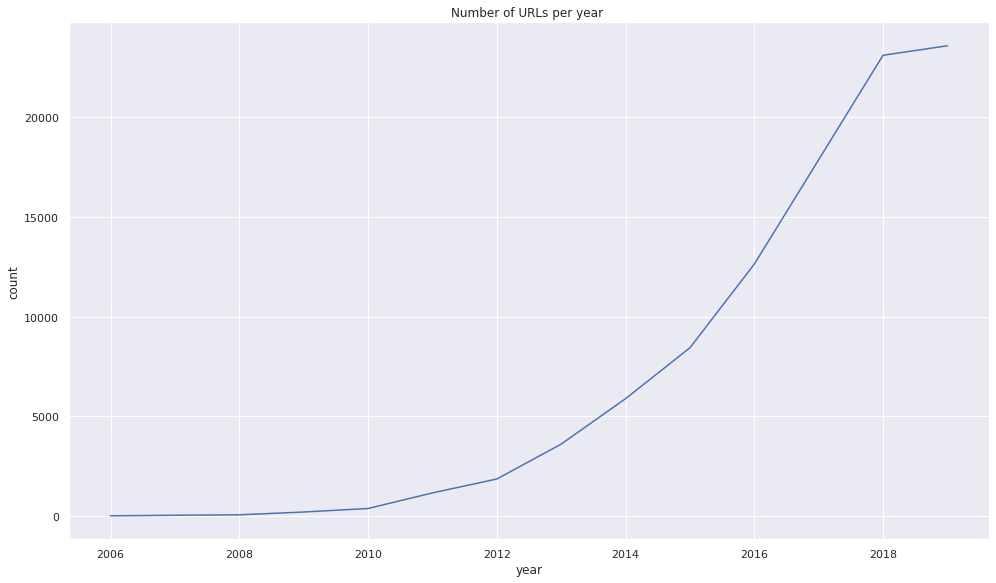

In [247]:
# count URL per year
pd_url_data['count'] = 1
pd_url_data_UrlsPerYear = pd_url_data.groupby(["year"]).count()['count'].reset_index()
# print(pd_url_data_UrlsPerYear)
# pd_url_data_videosWithUrlsPerYear = pd_url_data.groupby('year')['hash'].nunique().reset_index()
# print(pd_url_data_videosWithUrlsPerYear)

plt.figure()
sns.lineplot(x="year", y="count",markers=True, dashes=False, data=pd_url_data_UrlsPerYear)
plt.title("Number of URLs per year ")
plt.tight_layout()


### Channel and domain counts

In [248]:
# count unique videos for each channel
videoCountForChannel = pd_url_data.groupby('channelId')['hash'].nunique()
# add videoCountForChannel as column
pd_url_data['videoCountForChannel'] = pd_url_data['channelId'].map(videoCountForChannel)

# count unique videos for each domain
videoCountForDomain = pd_url_data.groupby('domain')['hash'].nunique()
# add videoCountForDomain as column
pd_url_data['videoCountForDomain'] = pd_url_data['domain'].map(videoCountForDomain)

# count unique channels for domain
channelCountForDomain = pd_url_data.groupby('domain')['channelId'].nunique()
# add channelCountForDomain as column
pd_url_data['channelCountForDomain'] = pd_url_data['domain'].map(channelCountForDomain)

# add channels/videos for domains
pd_url_data['channelDivVideoForDomain'] = round(pd_url_data['channelCountForDomain'] / pd_url_data['videoCountForDomain'], 2)

### Top domains

In [249]:
# reset count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False).reset_index()
# add diversity measure
pd_url_data_groupedDomain['videoCountForDomain'] = pd_url_data_groupedDomain['domain'].map(videoCountForDomain)
pd_url_data_groupedDomain['channelCountForDomain'] = pd_url_data_groupedDomain['domain'].map(channelCountForDomain)
pd_url_data_groupedDomain['channelDivVideoForDomain'] = pd_url_data_groupedDomain['channelCountForDomain'] / pd_url_data_groupedDomain['videoCountForDomain']

# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
with pd.option_context('display.precision', 2):
    display(pd_url_data_groupedDomain[['domain','count','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']].head(limit).style.hide_index()) 

Top 15 domains


domain,count,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
youtube.com,34659,14150,34635,0.41
facebook.com,11597,6623,11596,0.57
twitter.com,9271,5202,9271,0.56
instagram.com,5608,3983,5608,0.71
plus.google.com,1355,632,1355,0.47
play.google.com,1062,551,1062,0.52
amazon.com,1057,715,1056,0.68
twitch.tv,986,793,985,0.81
vk.com,962,663,962,0.69
amazon.de,552,307,551,0.56


### Which domains for 80% coverage?

In [265]:
total_urls = sum(pd_url_data_groupedDomain['count'])
pd_url_data_groupedDomain.loc[0, 'cummulative_percent'] = pd_url_data_groupedDomain.loc[0, 'count'] / total_urls
for i in range(1, len(pd_url_data_groupedDomain)):
    pd_url_data_groupedDomain.loc[i, 'cummulative_percent'] = pd_url_data_groupedDomain.loc[i - 1, 'cummulative_percent'] + (pd_url_data_groupedDomain.loc[i, 'count'] / total_urls)

print('Total URLs: %s' % (total_urls))
print('Unique domains: %s' % (len(pd_url_data_groupedDomain)))

with pd.option_context('display.precision', 2):
    display(pd_url_data_groupedDomain[pd_url_data_groupedDomain['cummulative_percent'] <= 0.8])

Total URLs: 94498
Unique domains: 8421


,domain,count,videoCountForDomain,channelCountForDomain,channelDivVideoForDomain,cummulative_percent
0,youtube.com,34659,34635,14150,0.41,0.37
1,facebook.com,11597,11596,6623,0.57,0.49
2,twitter.com,9271,9271,5202,0.56,0.59
3,instagram.com,5608,5608,3983,0.71,0.65
4,plus.google.com,1355,1355,632,0.47,0.66
...,...,...,...,...,...,...
71,aporasal.net,42,42,38,0.90,0.80
72,vod.sbs.co.kr,42,42,5,0.12,0.80
73,instant-gaming.com,42,42,29,0.69,0.80
74,drive.google.com,41,41,38,0.93,0.80


### Top domains per year: data for rank flow

In [251]:
#group by count and get top %%limit%% per year
pd_domains_by_year = pd_url_data.groupby(['year', 'domain']).count()['count'].reset_index().sort_values(ascending=False,by='count').groupby(['year']).head(limit).sort_values(ascending=False,by=['year','count'])

#pivot
pd_domains_by_year_pivot = pd_domains_by_year.pivot(index='domain',columns='year',values='count').reset_index()
pd_domains_by_year_pivot = pd_domains_by_year_pivot.set_index('domain')

# put in rankflow format
pd_rankflow = pd.DataFrame(range(0,limit))
for year, col in pd_domains_by_year_pivot.iteritems():
    col = col.dropna()
    col = col.sort_values(ascending=False)
    new = pd.DataFrame({str(year):col.index, str(year)+'_count':col.values})
    pd_rankflow = pd.concat([pd_rankflow,new],axis=1)

# pretty print
del pd_rankflow[0]
pd_rankflow = pd_rankflow.apply(lambda x: pd.Series(x.dropna().values)).fillna('')
with pd.option_context('display.precision', 0):
    display(pd_rankflow.style.hide_index()) 

2006,2006_count,2007,2007_count,2008,2008_count,2009,2009_count,2010,2010_count,2011,2011_count,2012,2012_count,2013,2013_count,2014,2014_count,2015,2015_count,2016,2016_count,2017,2017_count,2018,2018_count,2019,2019_count
cifraclub.com.br,1,youtube.com,7,youtube.com,14,youtube.com,50,youtube.com,130,youtube.com,405,youtube.com,542,youtube.com,1077,youtube.com,1911,youtube.com,2885,youtube.com,4504,youtube.com,6324,youtube.com,8330,youtube.com,8480
facebook.com,1,twitter.com,4,facebook.com,10,twitter.com,19,facebook.com,28,facebook.com,106,facebook.com,240,facebook.com,452,facebook.com,754,facebook.com,986,facebook.com,1479,facebook.com,2074,facebook.com,2648,facebook.com,2802
,,amazon.com,2,twitter.com,4,facebook.com,15,mahalo.com,28,twitter.com,83,twitter.com,208,twitter.com,395,twitter.com,600,twitter.com,881,twitter.com,1238,twitter.com,1678,twitter.com,2041,twitter.com,2095
,,facebook.com,2,banggood.com,2,instagram.com,6,twitter.com,25,mahalo.com,64,instagram.com,29,instagram.com,69,instagram.com,183,instagram.com,342,instagram.com,656,instagram.com,986,instagram.com,1490,instagram.com,1832
,,bbc.co.uk,1,guitartutee.com,2,play.google.com,4,zee5.com,7,french4you.net,49,itunes.apple.com,26,plus.google.com,40,plus.google.com,95,plus.google.com,154,plus.google.com,205,amazon.com,229,plus.google.com,353,play.google.com,332
,,flowkey.com,1,amazon.com,1,amazon.com,2,banggood.com,5,french4me.net,43,amazon.com,25,vod.sbs.co.kr,37,twitch.tv,81,twitch.tv,107,vk.com,155,plus.google.com,226,play.google.com,287,plus.google.com,255
,,instagram.com,1,google.com,1,chessworld.net,2,po.st,4,pinterest.com,28,program.kbs.co.kr,23,vk.com,35,vk.com,71,vk.com,100,twitch.tv,128,vk.com,214,amazon.com,279,amazon.com,249
,,music.apple.com,1,in.linkedin.com,1,megacursos.com,2,amazon.com,3,french4us.net,18,twitch.tv,17,amazon.com,30,amazon.de,36,amazon.de,82,amazon.com,116,play.google.com,208,twitch.tv,238,amazon.in,231
,,myspace.com,1,in.youtube.com,1,movietalkies.com,2,europe1.fr,3,euronews.com,15,imbc.com,15,twitch.tv,30,amazon.com,34,amazon.com,73,play.google.com,101,twitch.tv,184,vk.com,197,twitch.tv,189
,,nba.com,1,instagram.com,1,myspace.com,2,instagram.com,3,amazon.com,14,plus.google.com,14,tv.sbs.co.kr,29,onlinedatingsitesandservices.com,34,play.google.com,66,amazon.de,87,accounts.google.com,121,amazon.in,183,vk.com,180


### Top hosts

In [252]:
# add count column
pd_url_data['count'] = 1 
# count hosts in URLs data set and sort in reverse
pd_url_data_groupedHost = pd_url_data.groupby(["host"]).count()['count'].sort_values(ascending=False).reset_index()
pd_url_data_groupedHost = pd_url_data_groupedHost[pd_url_data_groupedHost['host']!=""] # remove empty for as of yet unresolved URLs
# print header
print("Top %s hosts" % (limit)) 
# print most used domains overall
display(pd_url_data_groupedHost.head(limit).style.hide_index())

Top 15 hosts


host,count
youtube.com,34747
facebook.com,11694
twitter.com,9298
instagram.com,5610
google.com,3310
amazon.com,1068
twitch.tv,1033
vk.com,971
apple.com,874
amazon.de,553


### Top deep links

In [253]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False).reset_index().head(limit)

# add diversity measure
pd_url_data_groupedUrl = clean_data(pd_url_data_groupedUrl,False)

pd_url_data_groupedUrl['channelCountForDomain'] = pd_url_data_groupedUrl['domain'].map(channelCountForDomain)
pd_url_data_groupedUrl['videoCountForDomain'] = pd_url_data_groupedUrl['domain'].map(videoCountForDomain)
pd_url_data_groupedUrl['channelDivVideoForDomain'] = round(pd_url_data_groupedUrl['channelCountForDomain'] / pd_url_data_groupedUrl['videoCountForDomain'],2)

# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
with pd.option_context('display.precision', 2):
    display(pd_url_data_groupedUrl.style.hide_index())

# free up memory
del pd_url_data_groupedUrl
gc.collect()

Top 15 resolvedUrl


resolvedUrl,count,domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
https://www.instagram.com/accounts/login,211,instagram.com,3983,5608,0.71
https://www.zee5.com,114,zee5.com,15,153,0.10
https://unacademy.com/unavailable,101,unacademy.com,31,101,0.31
https://www.youtube.com/error?src=404,90,youtube.com,14150,34635,0.41
https://www.facebook.com/euronews,83,facebook.com,6623,11596,0.57
http://incompetech.com,66,incompetech.com,137,154,0.89
https://www.youtube.com/user/euronewsnetwork/channels,65,youtube.com,14150,34635,0.41
https://www.youtube.com/playlist?list...,57,youtube.com,14150,34635,0.41
https://onlinedatingsitesandservices.com/forums/forum/question-and-answer,56,onlinedatingsitesandservices.com,1,60,0.02
https://creativecommons.org/licenses/by/4.0,55,creativecommons.org,150,172,0.87


3570

In [254]:
# free up memory
del videoCountForChannel
del videoCountForDomain
del channelCountForDomain
gc.collect()

21

### Top TLDs

In [255]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) # @todo, could also do based on icann_domains
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False).reset_index()
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
display(pd_url_data_groupedTld.head(limit).style.hide_index())

Top 15 TLDs


tld,count
com,82461
tv,1832
in,898
de,870
net,851
org,567
me,538
br,527
ru,504
kr,343


### Top domains per TLD

In [256]:
# for each tld, get limit domain
print("Top domains per TLD")
for tld in pd_url_data_groupedTld.head(limit)['tld']:
    top_domains_for_tld = pd_url_data[pd_url_data['tld']==tld].groupby(['tld','domain'])['hash'].nunique().sort_values(ascending=False)
    display(top_domains_for_tld[:limit])

# free up mmemory
del pd_url_data_groupedTld
del top_domains_for_tld
gc.collect()

Top domains per TLD


tld  domain             
com  youtube.com            34635
     facebook.com           11596
     twitter.com             9271
     instagram.com           5608
     plus.google.com         1355
     play.google.com         1062
     amazon.com              1056
     vk.com                   962
     soundcloud.com           545
     accounts.google.com      513
     itunes.apple.com         430
     pinterest.com            362
     patreon.com              350
     apps.apple.com           312
     open.spotify.com         233
Name: hash, dtype: int64

tld  domain         
tv   twitch.tv          985
     ruptly.tv           28
     ns7.tv              24
     samaa.tv            21
     city42.tv           17
     vidol.tv            16
     espreso.tv          16
     tfc.tv              16
     sathiyam.tv         15
     qazaqstan.tv        14
     britishpathe.tv     14
     vizionplus.tv       13
     de.twitch.tv        13
     somoynews.tv        12
     beritasatu.tv       12
Name: hash, dtype: int64

tld  domain          
in   amazon.in           512
     360dms.in            28
     next9news.in         24
     aninews.in           24
     etv.co.in            22
     10tv.in              18
     tv5news.in           15
     aajtak.in            15
     odishatv.in          10
     live.odishatv.in     10
     onlinejob.net.in      9
     wynk.in               9
     indiatoday.in         8
     gaonmajha.in          7
     ibc24.in              7
Name: hash, dtype: int64

tld  domain        
de   amazon.de         551
     pietsmiet.de       23
     mmoga.de           15
     elbster.de         13
     3dsupply.de        11
     gadarol.de         10
     welt.de             9
     tumilostore.de      8
     skillgaming.de      7
     lpmitkev.de         6
     shirt-tube.de       5
     igvault.de          5
     sat1.de             4
     getshirts.de        4
     bild.de             4
Name: hash, dtype: int64

tld  domain              
net  datinglogic.net         57
     french4you.net          54
     french4me.net           47
     aporasal.net            42
     atharori.net            41
     minecraftforum.net      22
     one31.net               21
     french4us.net           19
     alnaharlive.net         16
     videos.telesurtv.net    14
     minecraft.net           13
     almayadeen.net          13
     chessworld.net          12
     kinguin.net             12
     elbaladtv.net           11
Name: hash, dtype: int64

tld  domain              
org  creativecommons.org     172
     rfa.org                  15
     en.wikipedia.org         13
     ap.org                   12
     usagym.org               11
     twinmusicom.org          10
     pbs.org                  10
     khabrainabhitak.org      10
     archive.org               9
     democracynow.org          7
     mahendras.org             7
     nutritionfacts.org        6
     kexp.org                  6
     freemusicarchive.org      5
     ocremix.org               5
Name: hash, dtype: int64

tld  domain                   
me   rstyle.me                    219
     paypal.me                     73
     line.me                       57
     nettermscondition.pgtb.me     29
     store.line.me                 28
     t.me                          20
     migre.me                      16
     telegram.me                   15
     zalo.me                        9
     brightside.me                  7
     fbl.me                         6
     lineblog.me                    4
     timeline.line.me               3
     viid.me                        3
     vid.me                         3
Name: hash, dtype: int64

tld  domain                     
br   amazon.com.br                  29
     tvbrasil.ebc.com.br            11
     suamusica.com.br                9
     sbt.com.br                      9
     palcomp3.com.br                 8
     pagseguro.uol.com.br            8
     camara.leg.br                   6
     rs21.com.br                     6
     tecnodia.com.br                 6
     padrim.com.br                   5
     produto.mercadolivre.com.br     5
     tvcorreio.com.br                5
     app.monetizze.com.br            5
     tvgazeta.com.br                 5
     studiopc.com.br                 5
Name: hash, dtype: int64

tld  domain       
ru   ok.ru            143
     tv-soyuz.ru       33
     my.mail.ru        13
     pravda.ru          8
     chetv.ru           5
     aliexpress.ru      5
     dom2.ru            5
     ctc.ru             5
     1tv.ru             4
     stopgame.ru        4
     ria.ru             4
     infourok.ru        4
     drive2.ru          4
     donatepay.ru       4
     zen.yandex.ru      4
Name: hash, dtype: int64

tld  domain            
kr   vod.sbs.co.kr         42
     tv.sbs.co.kr          37
     program.kbs.co.kr     33
     news.sbs.co.kr        23
     n.sbs.co.kr           21
     netv.sbs.co.kr        20
     ytn.co.kr             18
     asq.kr                18
     yonhapnewstv.co.kr    12
     programs.sbs.co.kr    10
     home.ebs.co.kr         8
     yonhapnews.co.kr       8
     kbsworld.co.kr         7
     program.sbs.co.kr      7
     twip.kr                6
Name: hash, dtype: int64

tld  domain             
jp   amazon.co.jp           76
     ameblo.jp              15
     dova-s.jp              14
     fanblogs.jp            12
     nicovideo.jp           10
     musmus.main.jp          8
     ch.nicovideo.jp         8
     com.nicovideo.jp        7
     uuum.co.jp              6
     tv-tokyo.co.jp          6
     news.tv-asahi.co.jp     6
     ch-sakura.jp            5
     freem.ne.jp             3
     tastemade.jp            3
     ttrinity.jp             3
Name: hash, dtype: int64

tld  domain         
gg   discord.gg         269
     navi.gg              5
     smash.gg             5
     op.gg                3
     rainmaker.gg         3
     tele.gg              3
     fr.millenium.gg      2
     arma.gg              1
     engage.gg            1
     euw.op.gg            1
     lolclass.gg          1
     lolwiz.gg            1
     mobalytics.gg        1
     na.op.gg             1
Name: hash, dtype: int64

tld  domain          
co   apple.co            136
     t.co                 38
     vine.co              12
     gradeup.co            8
     uspstudios.co         6
     tradegenius.co        5
     mbsy.co               4
     edureka.co            4
     secretlab.co          3
     cartn.co              3
     teleantioquia.co      3
     ww38.rdrs.co          2
     portafolio.co         2
     sb17.co               2
     kit.co                2
Name: hash, dtype: int64

tld  domain                
uk   amazon.co.uk              70
     dailymail.co.uk           24
     bbc.co.uk                 19
     shop.spreadshirt.co.uk    10
     gtomega.co.uk              9
     pcspecialist.co.uk         6
     freesfx.co.uk              5
     gametee.co.uk              5
     shopstyle.co.uk            5
     telegraph.co.uk            5
     pinterest.co.uk            5
     andertons.co.uk            4
     betintl.co.uk              3
     bassrebels.co.uk           3
     carbuyer.co.uk             3
Name: hash, dtype: int64

tld  domain
st   po.st     215
     sh.st       2
Name: hash, dtype: int64

87

# Monetization

## Allowed merch and monetization on Github
https://support.google.com/youtube/answer/6083754?hl=en#zippy=%2Clist-of-approved-merchandise-sites

In [257]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd
print("Number of merch sites: %s" % (len(merch)))
print("Number of crowd sites: %s" % (len(crowd)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

Number of merch sites: 191
Number of crowd sites: 85


## Commission
*Warning:* This is done on host, rather than domain (as too much happened in subdomains)


In [258]:
from allowed_3rdparty import commission, commission_extra
print("Number of commission sites: %s" % (len(commission)))
print("Number of commission_extra sites: %s" % (len(commission_extra)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["commission"] = np.where(pd_url_data["host"].isin(commission), True, False) 
pd_url_data["commission_extra"] = np.where(pd_url_data["host"].isin(commission_extra), True, False) 

Number of commission sites: 83
Number of commission_extra sites: 7


In [259]:
# find possible extra commission domains 
if print_commission_extra:
    pd_url_data['count'] = 1 # reset count column
    commission_domains = pd_url_data[pd_url_data.host.str.contains('amazon\.|amazonaws|getshirts|airbnb|movavi|audible|joinhoney|twitch|tripadvisor|shopstyle|adobe|sellfy|clickfunnels|clickbank|etsy|bluehost|shareasale|hubspot|sendinblue|rakutenmarketing|adworkmedia|jvzoo|markethealth|maxbounty|ebay|bhcosmetics|affiliateprograms|sigma-beauty|shopify|agoda|jimpartners|ipage|\.media\.net|leadpages', regex=True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
    print("Possible extra commission:")
    for row in commission_domains['host']:
        if row not in commission:
            print("'%s'," % row)
    print("")

    pd_url_data['count'] = 1 # reset count column
    commission_domains_extra = pd_url_data[pd_url_data.host.str.contains('banggood|aliexpress|paypal|skillshare', regex= True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
    print("Possible extra commission extra:")
    for row in commission_domains_extra['host']:
        if row not in commission_extra:
            print("'%s',"%row)
    print("")

## Save monetization info to csv for grounded coding

In [260]:
if print_commission_extra:
    # merge domain count with pd_url_data
    pd_url_data_merch_cats = pd_url_data[['domain', 'crowd', 'merch', 'commission', 'commission_extra']] #.query('crowd==True | merch==True | commission==True | commission_extra==True')
    pd_url_data_merch_cats = pd_url_data_groupedDomain.merge(pd_url_data_merch_cats, on='domain', how='left')
    pd_url_data_merch_cats = pd_url_data_merch_cats.drop_duplicates()
    # make category descriptions
    pd_url_data_merch_cats = pd_url_data_merch_cats.replace({'crowd': {True: 'crowd', False: ''}, 'merch': {True: 'merch', False: ''}, 'commission': {True: 'commission', False: ''}, 'commission_extra': {True: 'extra', False: ''}})
    cats = pd_url_data_merch_cats['crowd']+pd_url_data_merch_cats['merch']+pd_url_data_merch_cats['commission']+pd_url_data_merch_cats['commission_extra']
    pd_url_data_merch_cats['category'] = cats
    pd_url_data_merch_cats = pd_url_data_merch_cats.drop(['crowd', 'merch', 'commission', 'commission_extra'], axis=1)
    print(pd_url_data_merch_cats.head(10))
    # save to csv
    pd_url_data_merch_cats[0:1000].to_csv('categorization' + str(sample_size) + '.csv', index=False)

    # Free up memory
    del pd_url_data_merch_cats
    gc.collect()

## Load channel data

In [261]:
# load channel data
pd_channel_data = pd.read_csv('channel_data/channels_from_jsoncache_100k_update.csv', names=channel_columns)

# delete columns we won't use
pd_channel_data = pd_channel_data[["id","subscriberCount","videoCount","commentCount","viewCount","country","publishedAt","keywords","topics","wikitopics"]]

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

# join with url data on channelId
pd_url_data = pd_url_data.join(pd_channel_data.set_index('id'), on='channelId', lsuffix='_urls', rsuffix='_channel')

# cast columns in right type
pd_url_data['date_channel'] = pd.to_datetime(pd_url_data['publishedAt'])
del pd_url_data['publishedAt']

# free up memory
del pd_channel_data
gc.collect()

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")


/home/erik/.conda/envs/venv_yt_urls/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (3,4,5,6,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [262]:
# make a column where at least one of monetized or crowd is true
pd_url_data['monetized'] = pd_url_data['merch'] | pd_url_data['crowd'] 

# get number of video ids where monetized = True
monetized_videos = pd_url_data[pd_url_data['monetized']==True]['hash'].unique()
monetized_video_number = len(monetized_videos)
total_video_number = len(pd_url_data['hash'].unique())
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)
# do the same for channels
monetized_channels = pd_url_data[pd_url_data['monetized']==True]['channelId'].unique()
monetized_channel_number = len(monetized_channels)
total_channel_number = len(pd_url_data['channelId'].unique())
percent_channel_monetized = round(monetized_channel_number/total_channel_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))
print("%s channels are monetized out of %s total channels, that is %s%%" % (monetized_channel_number, total_channel_number, percent_channel_monetized))

# free up memory
del monetized_videos
del monetized_channels
gc.collect()

1829 videos are monetized out of 98717 total videos, that is 1.85%
1402 channels are monetized out of 31135 total channels, that is 4.5%


0

## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type
Beware: below calculations assume that merch or crowd URLs are only mentioned once per video


crowd domain count


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
patreon.com,298,350,0.85
streamlabs.com,85,95,0.89
apoia.se,15,15,1.00
gofundme.com,11,13,0.85
kickstarter.com,6,6,1.00
tipeee.com,6,6,1.00
patronite.pl,3,3,1.00
change.org,3,3,1.00
vakinha.com.br,3,3,1.00
indiegogo.com,2,2,1.00




crowd domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                  14.00                14.00                     14.00
mean                   31.29                35.93                      0.95
std                    79.80                93.63                      0.10
min                     1.00                 1.00                      0.67
25%                     2.00                 2.25                      0.92
50%                     3.00                 3.00                      1.00
75%                     9.75                11.25                      1.00
max                   298.00               350.00                      1.00


merch domain count


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
soundcloud.com,455,545,0.83
itunes.apple.com,240,430,0.56
teespring.com,78,84,0.93
store.steampowered.com,55,65,0.85
etsy.com,28,29,0.97
store.line.me,23,28,0.82
hungama.com,13,14,0.93
districtlines.com,12,13,0.92
3dsupply.de,11,11,1.00
kkbox.com,8,8,1.00




merch domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                  49.00                49.00                     49.00
mean                   20.57                27.06                      0.92
std                    72.90                97.89                      0.15
min                     1.00                 1.00                      0.40
25%                     1.00                 1.00                      0.92
50%                     2.00                 2.00                      1.00
75%                     5.00                 8.00                      1.00
max                   455.00               545.00                      1.00




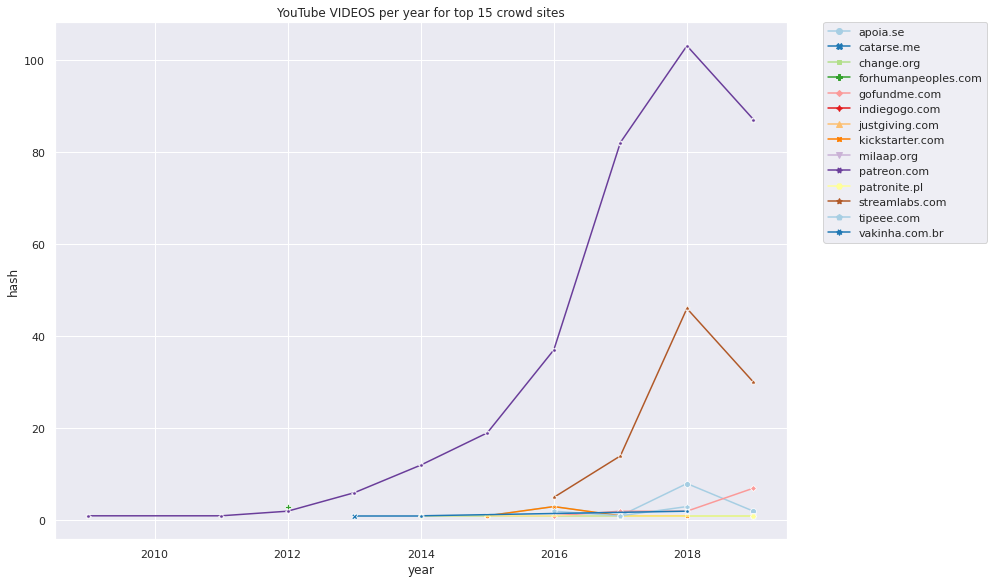

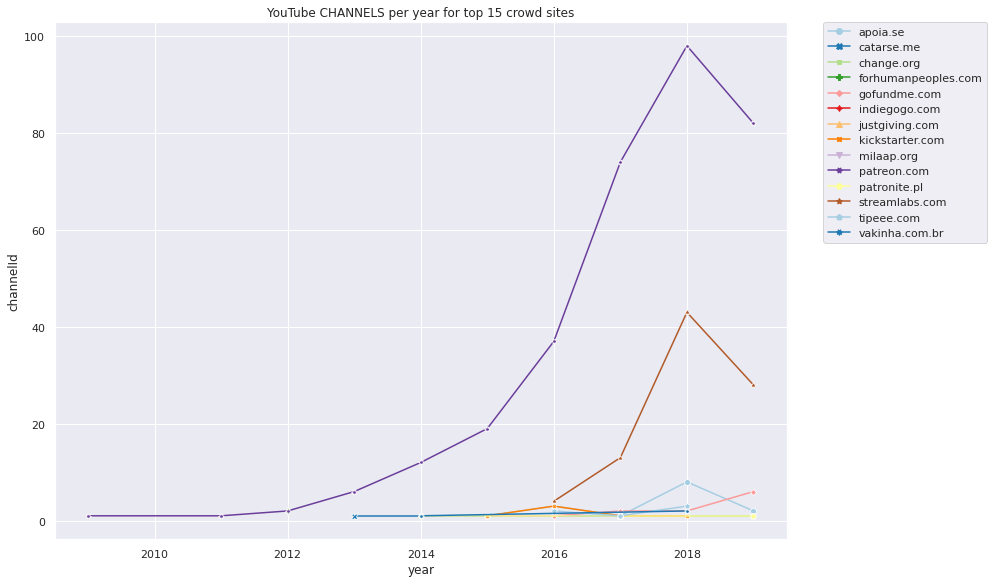

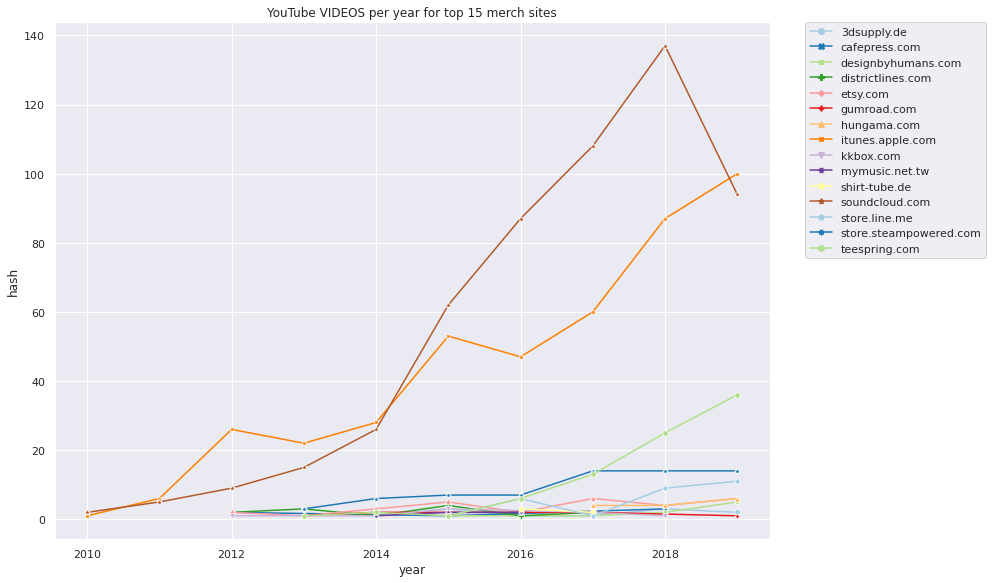

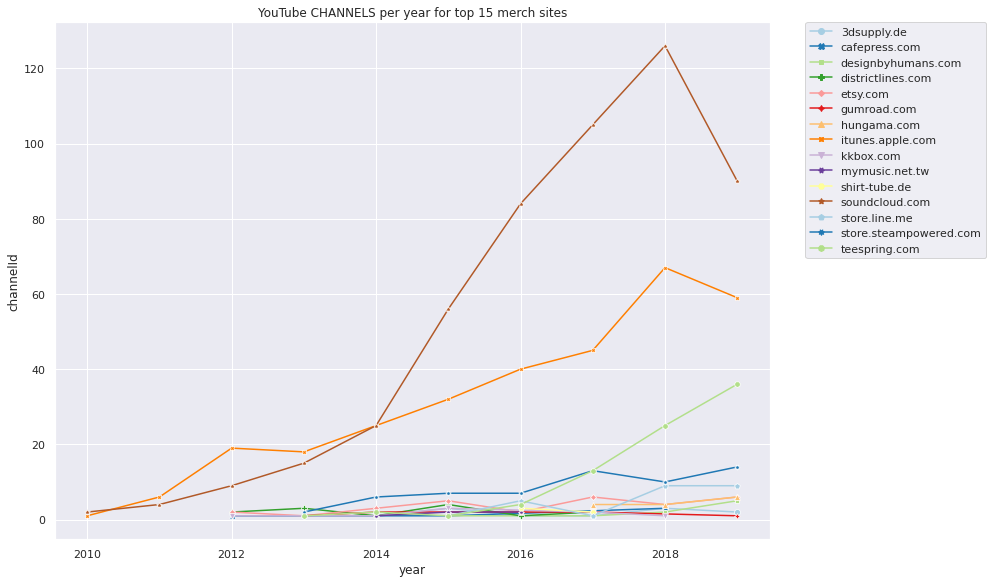

In [263]:
domain_stats = {}
for type in ['crowd','merch']:

    ''' Describe '''
    domain_stats[type] = pd_url_data[['domain','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']][pd_url_data[type]==True].drop_duplicates()

    # print header
    print("%s domain count" % type)
    # print most used TYPE domains
    domain_stats[type]['channelCountForDomain'] = domain_stats[type]['channelCountForDomain'].astype(int)
    domain_stats[type]['videoCountForDomain'] = domain_stats[type]['videoCountForDomain'].astype(int)

    with pd.option_context('display.precision', 2):
        display(domain_stats[type].sort_values(by=['channelCountForDomain','channelDivVideoForDomain'],ascending=False).head(limit).style.hide_index())
        print("\n")
        # print TYPE domain stats
        print("%s domain stats" % type)
        print(domain_stats[type].describe())
        print("\n")

    ''' Graph '''

    # filter pd_url_data to only retain info for rows with TYPE domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]

    # limit data by top overall TYPE domain for graph
    top_domains = {}
    top_domains[type] = domain_stats[type].sort_values(by="channelCountForDomain",ascending=False)['domain'][0:limit]
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count videos by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['hash'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)
    
    # plot rise of TYPE sites, for videos per year
    plt.figure()
    sns.lineplot(x="year", y="hash", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube VIDEOS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    # count channels by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['channelId'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)

    # plot rise of TYPE sites, for channels per year
    plt.figure()
    sns.lineplot(x="year", y="channelId", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube CHANNELS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## @todo

* Work on the referral list
   * √ Observations
      * √ not all monetization sites are part of our list getshirts.de
      * √ Stuff definitely missing on our lists: getshirts.de, amazon.{tld}, banggood, aliexpress, skillshare, …
   * √ Get 1000 domains of all URLs (overall and based on channel)
      * √ Already qualify as crowd, merch, commission
      * Continue the rest of the sites and see whether they should be included or added to (other) list via emergent (grounded theory) coding
   * √ match on host (instead of domain)
* Overall observations
   * √ Background graph: number of URLs per year
   * √ Make RankFlow of top domains per year
   * √ Add diversity for Domains, top deep links
   * √ How many domains for 80% coverage?
   * Rather than thinking about URLs, think about views/subscriber numbers.
   
* Breakdows
   * subscriber tier
   * language & locale
   * category (channel & video)
   * year

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Channel categories. What hasn't been done at all in the last paper is looking at video categories. That may be done interestingly. Monetization per channel category. Channel classification is not done by video creators. 
	   * b = DataFrame(a.var1.str.split('|').tolist(), index=a.var2).stack()
	   * b = b.reset_index()[[0, 'var2']] # var1 variable is currently labeled 0
	   * b.columns = ['var1', 'var2'] # renaming var1
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Compare channel categories vs video categories. (But we need to import mysql database.) Is gonna be important when looking at descriptions and tags and such.
* Think of categories in terms of scatter plots. E.g. crowd funding vs merch and category. Size is number of videos.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)

Later
* Why are there ⅓ of URLs going to youtube.com and what do they link to (videos, channels?) Are they building a network, just like featuring or subscribing?
* Is the presence of other platforms a sign of cross-platform activity?
* Look into the means of production, e.g. free audio
* what kind of channels linked to the academic publishers?
* look into what's missing. The "(note-)book" of the dead.
	* https://www.youtube.com/error?src=404
	* unacademy.com/unavailable
* graphs, instead of absolute numbers, divide into number of videos per year
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 